# Build reference atlas from scratch

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download raw Dataset

In [4]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC
To: /Users/mohammad.lotfollahi/PycharmProjects/scarches/pbmc.h5ad
100%|███████████████████████████████████████| 2.06G/2.06G [00:19<00:00, 105MB/s]


'pbmc.h5ad'

In [99]:
adata = sc.read('pbmc.h5ad')

In [100]:
adata.X = adata.layers["counts"].copy()

In [102]:
adata = adata[adata.obs.study != "Villani"]

We now split the data into reference and query dataset to simulate the building process. Here we use the '10X' batch as query data.

In [202]:
target_conditions = ["10X"]
source_adata = adata[~adata.obs.study.isin(target_conditions)].copy()
target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
print(source_adata)
print(target_adata)

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


For a better model performance it is necessary to select HVGs. We are doing this by applying the scanpy.pp function highly_variable_genes(). The n_top_genes is set to 2000 here. Howeever, if you more complicated datasets you might have to  increase number of genes to capture more diversity in the data.

In [204]:
source_adata.raw = source_adata

In [205]:
source_adata

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [206]:
sc.pp.normalize_total(source_adata)

In [207]:
sc.pp.log1p(source_adata)

In [208]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="study",
    subset=True)

/Users/mohammad.lotfollahi/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


For consistency we set adata.X to be raw counts. In other datasets that may be already the case

In [209]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

### Create SCVI model and train it on reference dataset

Remember that the adata file has to have count data in adata.X for SCVI/SCANVI if not further specified.

In [111]:
sca.dataset.setup_anndata(source_adata, batch_key="batch")

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 21757 cells, 2000 vars, 8 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Create the SCVI model instance with ZINB loss as default. Insert "gene_likelihood='nb'," to change the reconstruction loss to NB loss.

In [112]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=True,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [113]:

vae.train(max_epochs=120)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 120/120: 100%|███████| 120/120 [12:37<00:00,  6.31s/it, loss=563, v_num=1]


The resulting latent representation of the data can then be visualized with UMAP

In [224]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
reference_latent.obs["batch"] = source_adata.obs["batch"].tolist()
reference_latent.obs["study"] = source_adata.obs["study"].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


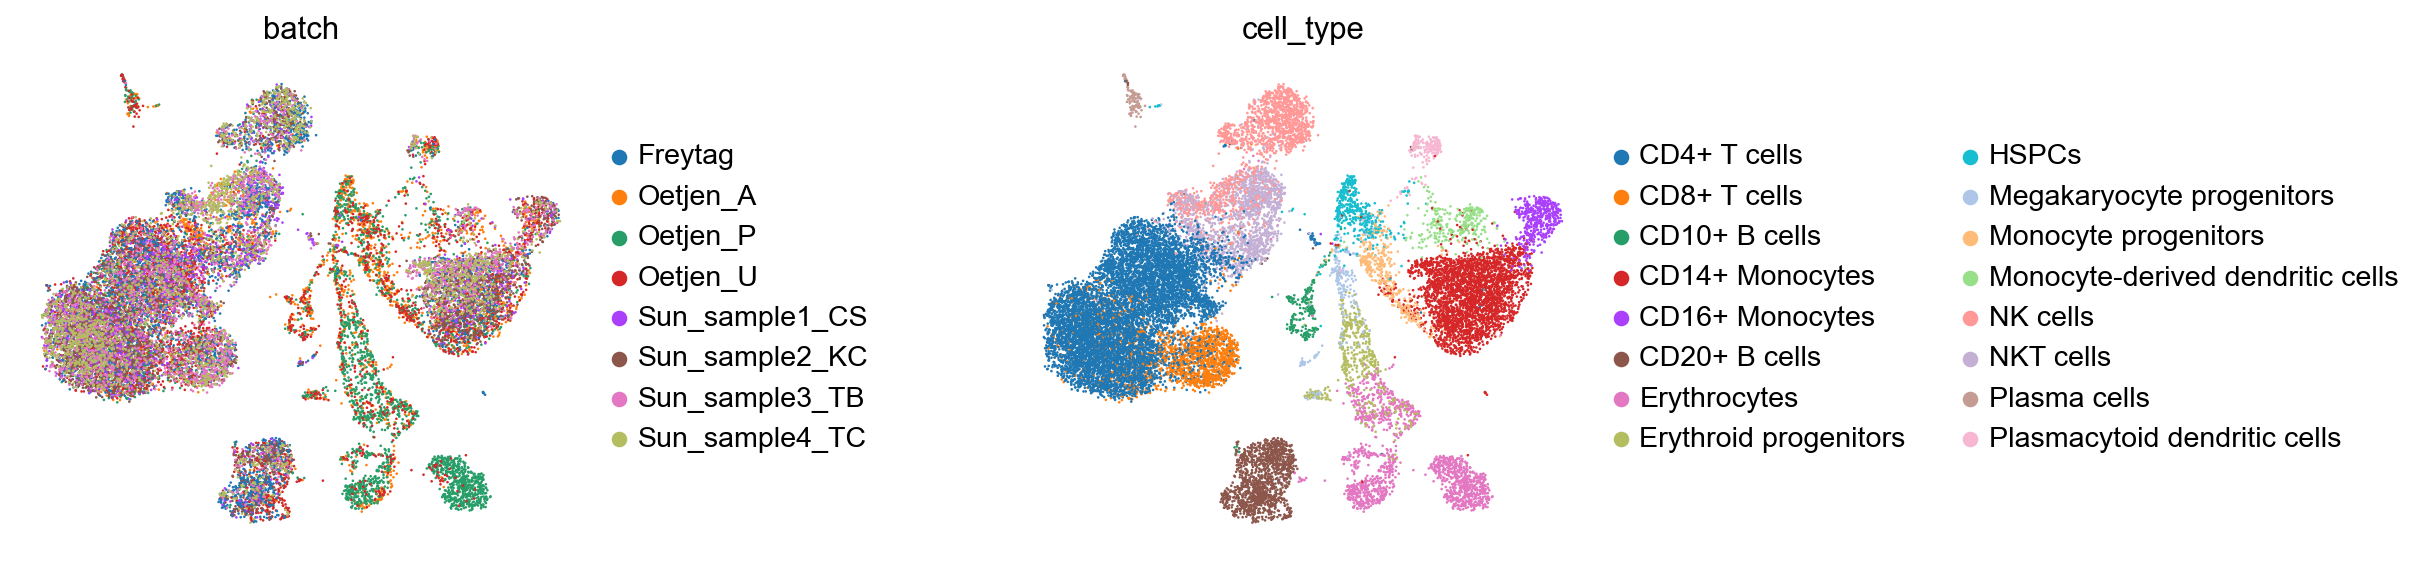

In [115]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use or also be uploaded for other researchers with via Zenodo. For the second option please also have a look at the Zenodo notebook.

In [116]:
ref_path = 'ref_model_pbmc_schpl/'
vae.save(ref_path, overwrite=True)

### Construct hierarchy for the reference using scHPL

In [222]:
reference_latent.obs.value_counts()

cell_type                     batch         
CD4+ T cells                  Oetjen_U          1652
                              Freytag           1238
Erythrocytes                  Oetjen_P          1219
CD4+ T cells                  Sun_sample2_KC    1162
                              Sun_sample1_CS    1054
                                                ... 
Plasmacytoid dendritic cells  Sun_sample4_TC      16
                              Freytag             11
Megakaryocyte progenitors     Sun_sample2_KC       8
Plasmacytoid dendritic cells  Sun_sample2_KC       7
Megakaryocyte progenitors     Sun_sample1_CS       6
Length: 91, dtype: int64

In [225]:
reference_latent.obs['celltype_batch'] = np.char.add(np.array(reference_latent.obs['cell_type'], dtype= str),
                                             np.array(reference_latent.obs['study'], dtype=str))

Starting tree:


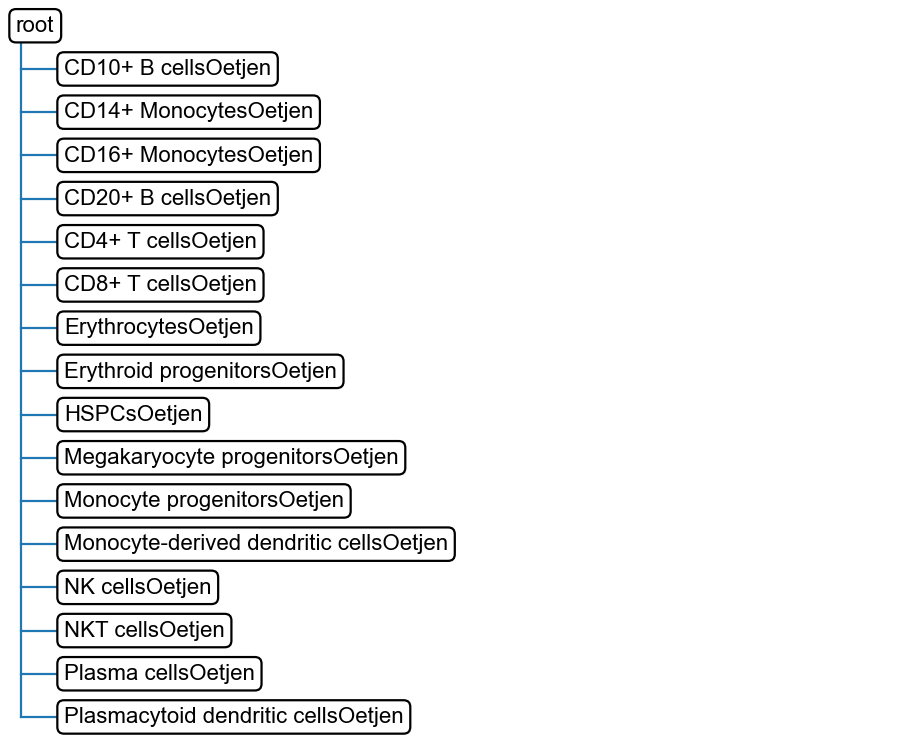


Adding dataset Freytag to the tree
These populations are missing from the tree: 
['CD8+ T cellsFreytag' 'Megakaryocyte progenitorsFreytag'
 'NK cellsFreytag' 'NKT cellsFreytag']

Updated tree:


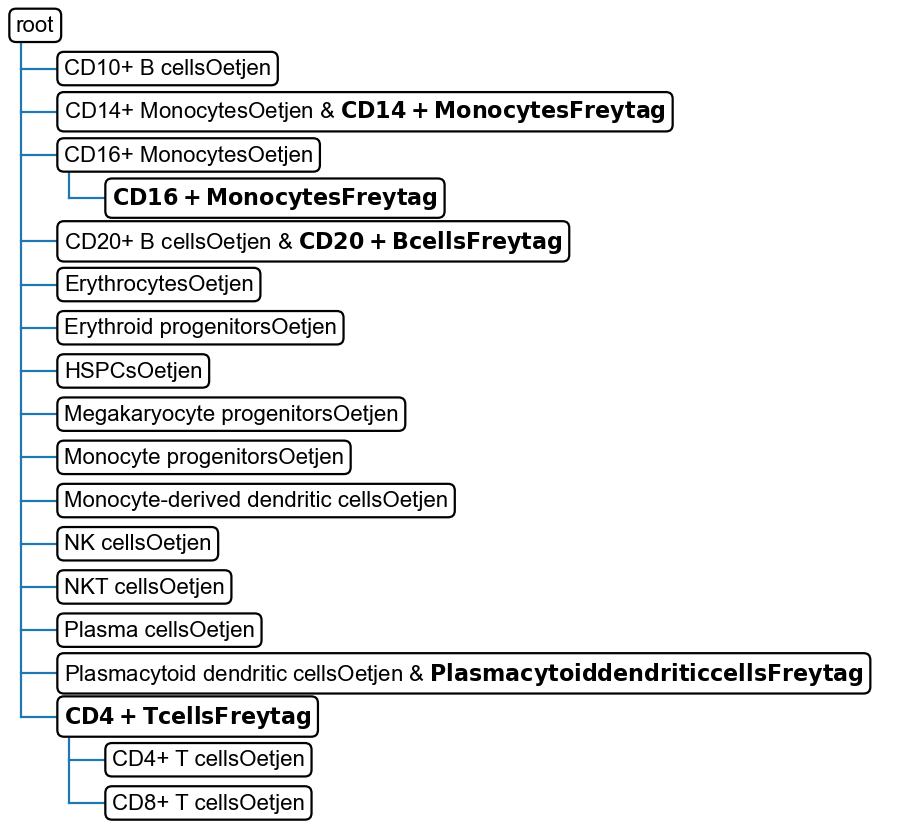


Adding dataset Sun to the tree
These populations are missing from the tree: 
['CD4+ T cellsSun' 'CD8+ T cellsSun' 'Megakaryocyte progenitorsSun'
 'NK cellsSun' 'NKT cellsSun']

Updated tree:


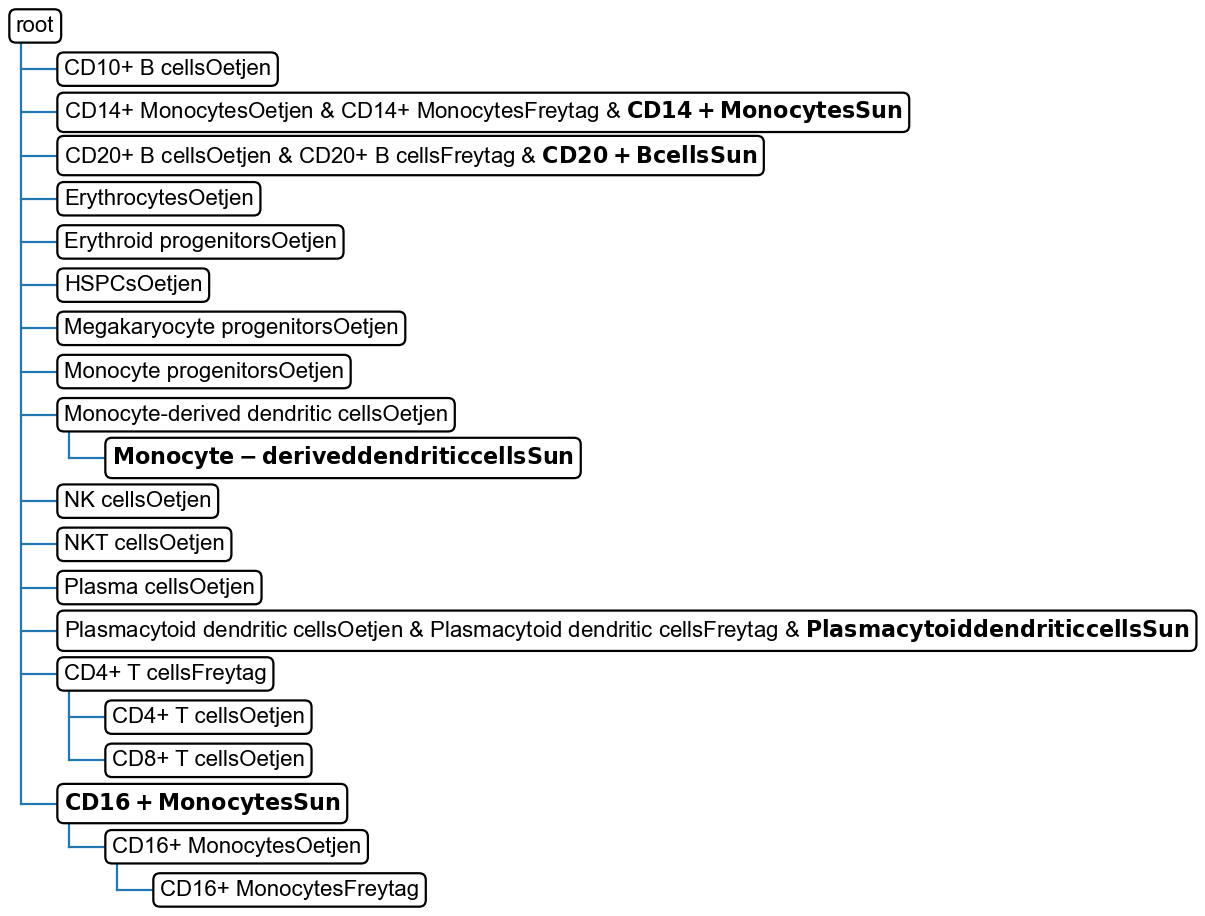

In [227]:
tree_ref, mp_ref = sca.classifiers.scHPL.learn_tree(data = reference_latent, 
                batch_key = 'study',
                batch_order = [ 'Oetjen', 'Freytag', 'Sun'],
                cell_type_key='celltype_batch',
                classifier = 'svm',
                dimred = False)

### Use pretrained reference model and apply surgery with a new query dataset to get a bigger reference atlas

Since the model requires the datasets to have the same genes we also filter the query dataset to have the same genes as the reference dataset.

In [128]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

We then can apply the model surgery with the new query dataset:

In [129]:
model = sca.models.SCVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)

Trying to set attribute `.uns` of view, copying.


INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 10727 cells, 2000 vars, 9 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [130]:
model.train(max_epochs=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 100/100: 100%|███████| 100/100 [04:03<00:00,  2.44s/it, loss=987, v_num=1]


In [134]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs["final_annotation"].tolist()
query_latent.obs['batch'] = target_adata.obs["batch"].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

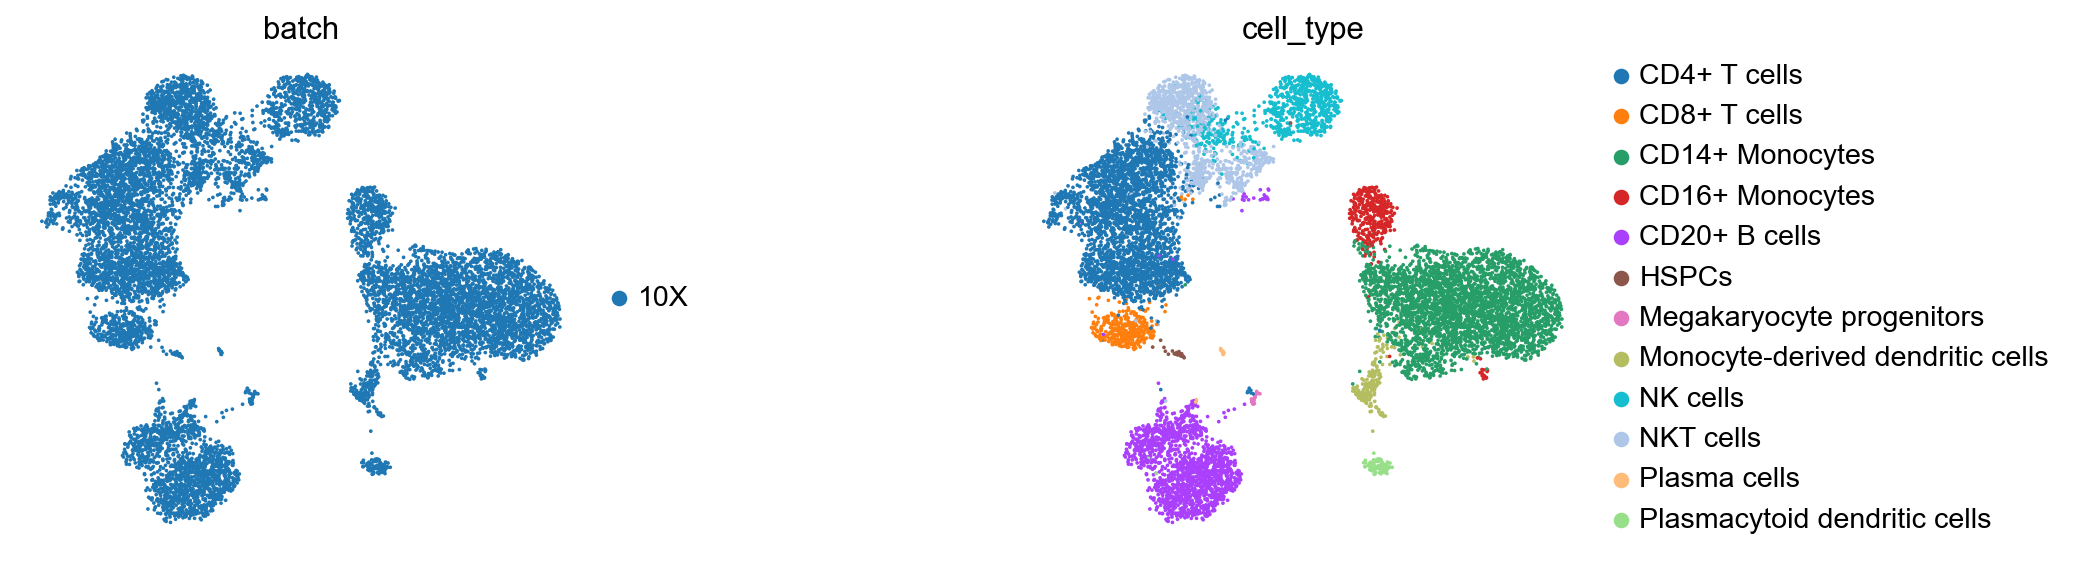

In [135]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

And again we can save or upload the retrained model for later use or additional extensions.

In [136]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [185]:
target_adata.obs.study = "10X"

In [187]:
target_adata

AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_scvi_batch', '_scvi_labels'
    uns: '_scvi'
    layers: 'counts'

In [195]:
target_adata.obs['celltype_batch'] = np.char.add(np.array(target_adata.obs['final_annotation'], dtype= str),
                                             np.array(target_adata.obs['study'], dtype=str))

In [196]:
target_adata.obs['celltype_batch']

index
AAACCCAAGCGCCCAT-1-10X                        CD4+ T cells10X
AAACCCAAGGTTCCGC-1-10X    Monocyte-derived dendritic cells10X
AAACCCACAGAGTTGG-1-10X                     CD14+ Monocytes10X
AAACCCACAGGTATGG-1-10X                            NK cells10X
AAACCCACATAGTCAC-1-10X                       CD20+ B cells10X
                                         ...                 
TTTGTTGGTGCGTCGT-1-10X                        CD4+ T cells10X
TTTGTTGGTGTCATGT-1-10X                     CD14+ Monocytes10X
TTTGTTGGTTTGAACC-1-10X                           NKT cells10X
TTTGTTGTCCAAGCCG-1-10X                        CD4+ T cells10X
TTTGTTGTCTTACTGT-1-10X                        CD4+ T cells10X
Name: celltype_batch, Length: 10727, dtype: object

In [212]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [216]:
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()
full_latent.obs['study'] = adata_full.obs["study"].tolist()


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 32484 cells, 2000 vars, 9 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [217]:
full_latent.obs

,cell_type,batch,study
0,CD16+ Monocytes,Oetjen_A,Oetjen
1,CD4+ T cells,Oetjen_A,Oetjen
2,CD14+ Monocytes,Oetjen_A,Oetjen
3,CD14+ Monocytes,Oetjen_A,Oetjen
4,NKT cells,Oetjen_A,Oetjen
...,...,...,...
32479,CD4+ T cells,10X,10X
32480,CD14+ Monocytes,10X,10X
32481,NKT cells,10X,10X
32482,CD4+ T cells,10X,10X


In [218]:
full_latent.obs['celltype_batch'] = np.char.add(np.array(full_latent.obs['cell_type'], dtype= str),
                                             np.array(full_latent.obs['study'], dtype=str))

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

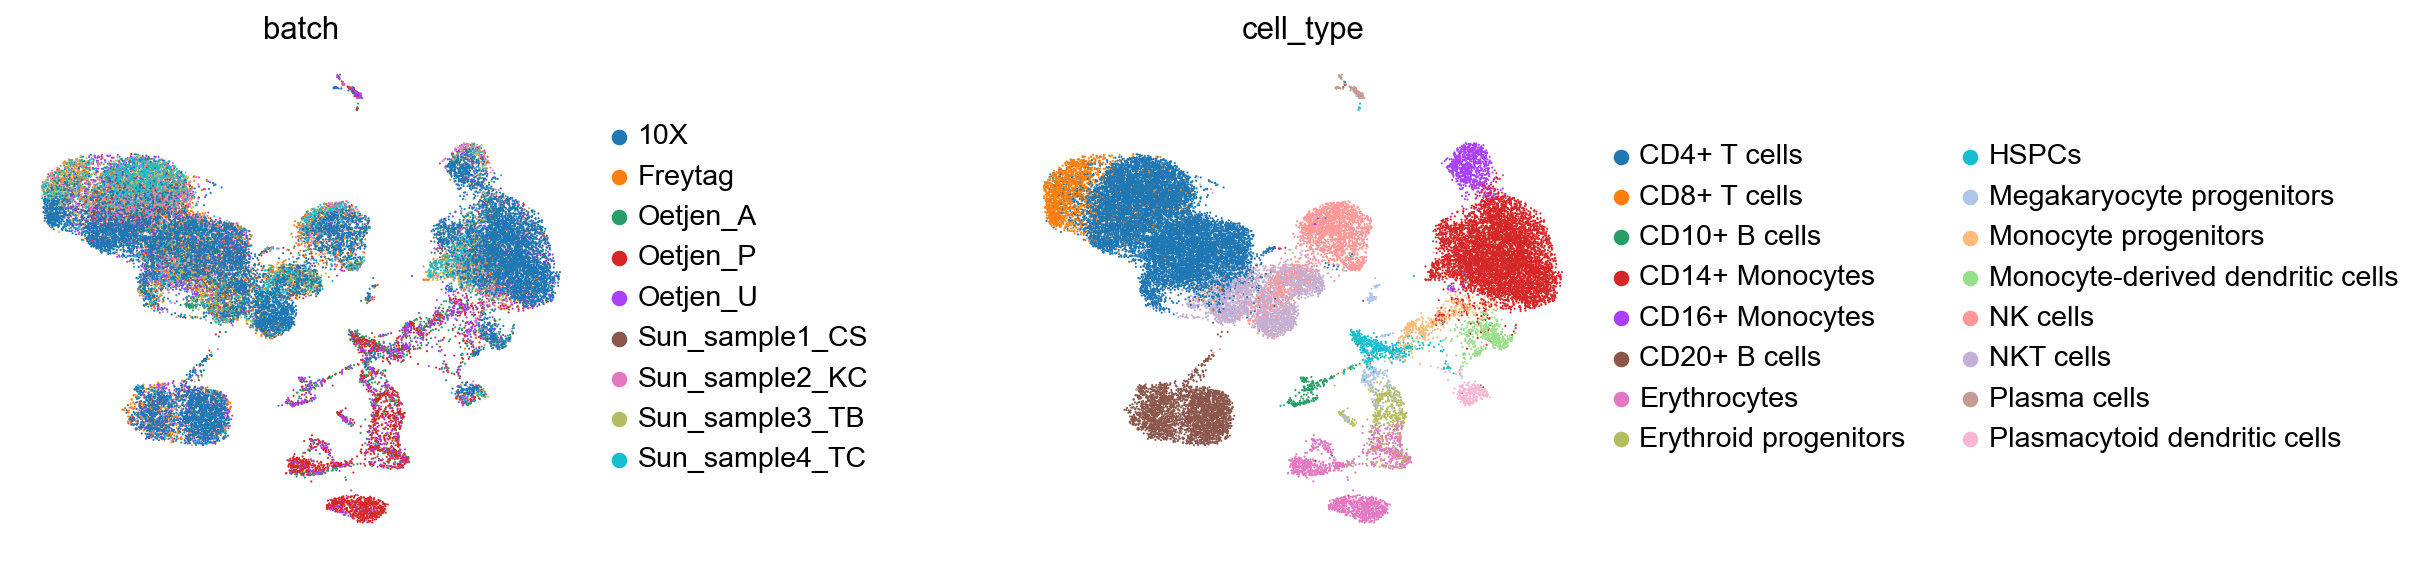

In [139]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [219]:
full_latent.obs['celltype_batch'].value_counts()

CD4+ T cellsSun                           4312
CD14+ Monocytes10X                        3388
CD4+ T cells10X                           2937
CD4+ T cellsOetjen                        2524
CD20+ B cells10X                          1546
ErythrocytesOetjen                        1502
CD14+ MonocytesSun                        1501
CD4+ T cellsFreytag                       1238
NKT cells10X                              1056
CD14+ MonocytesOetjen                      997
CD8+ T cellsOetjen                         985
NK cellsSun                                973
NK cells10X                                756
NKT cellsSun                               649
NKT cellsOetjen                            608
CD8+ T cellsSun                            578
CD20+ B cellsOetjen                        491
NK cellsFreytag                            476
Erythroid progenitorsOetjen                463
CD14+ MonocytesFreytag                     452
HSPCsOetjen                                445
NKT cellsFrey

Starting tree:


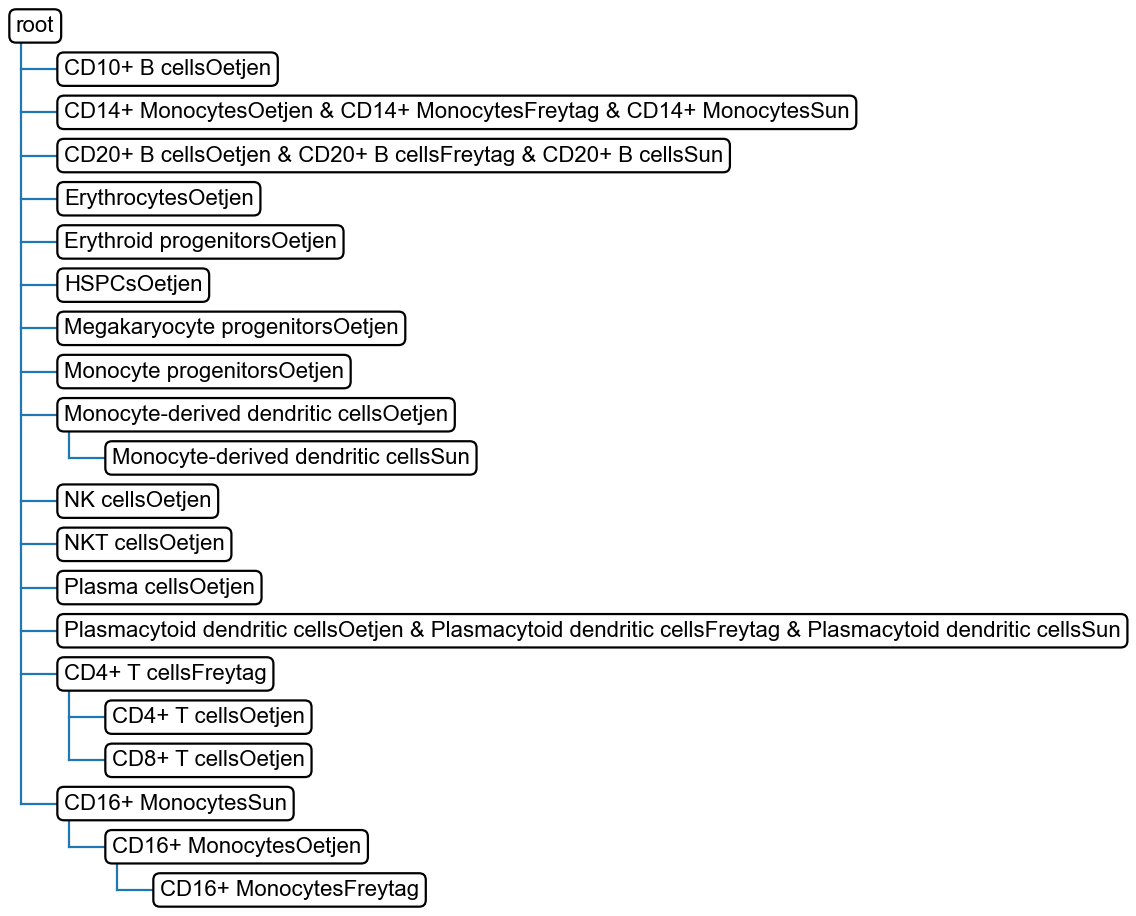


Adding dataset 10X to the tree
These populations are missing from the tree: 
['CD16+ Monocytes10X']

Updated tree:


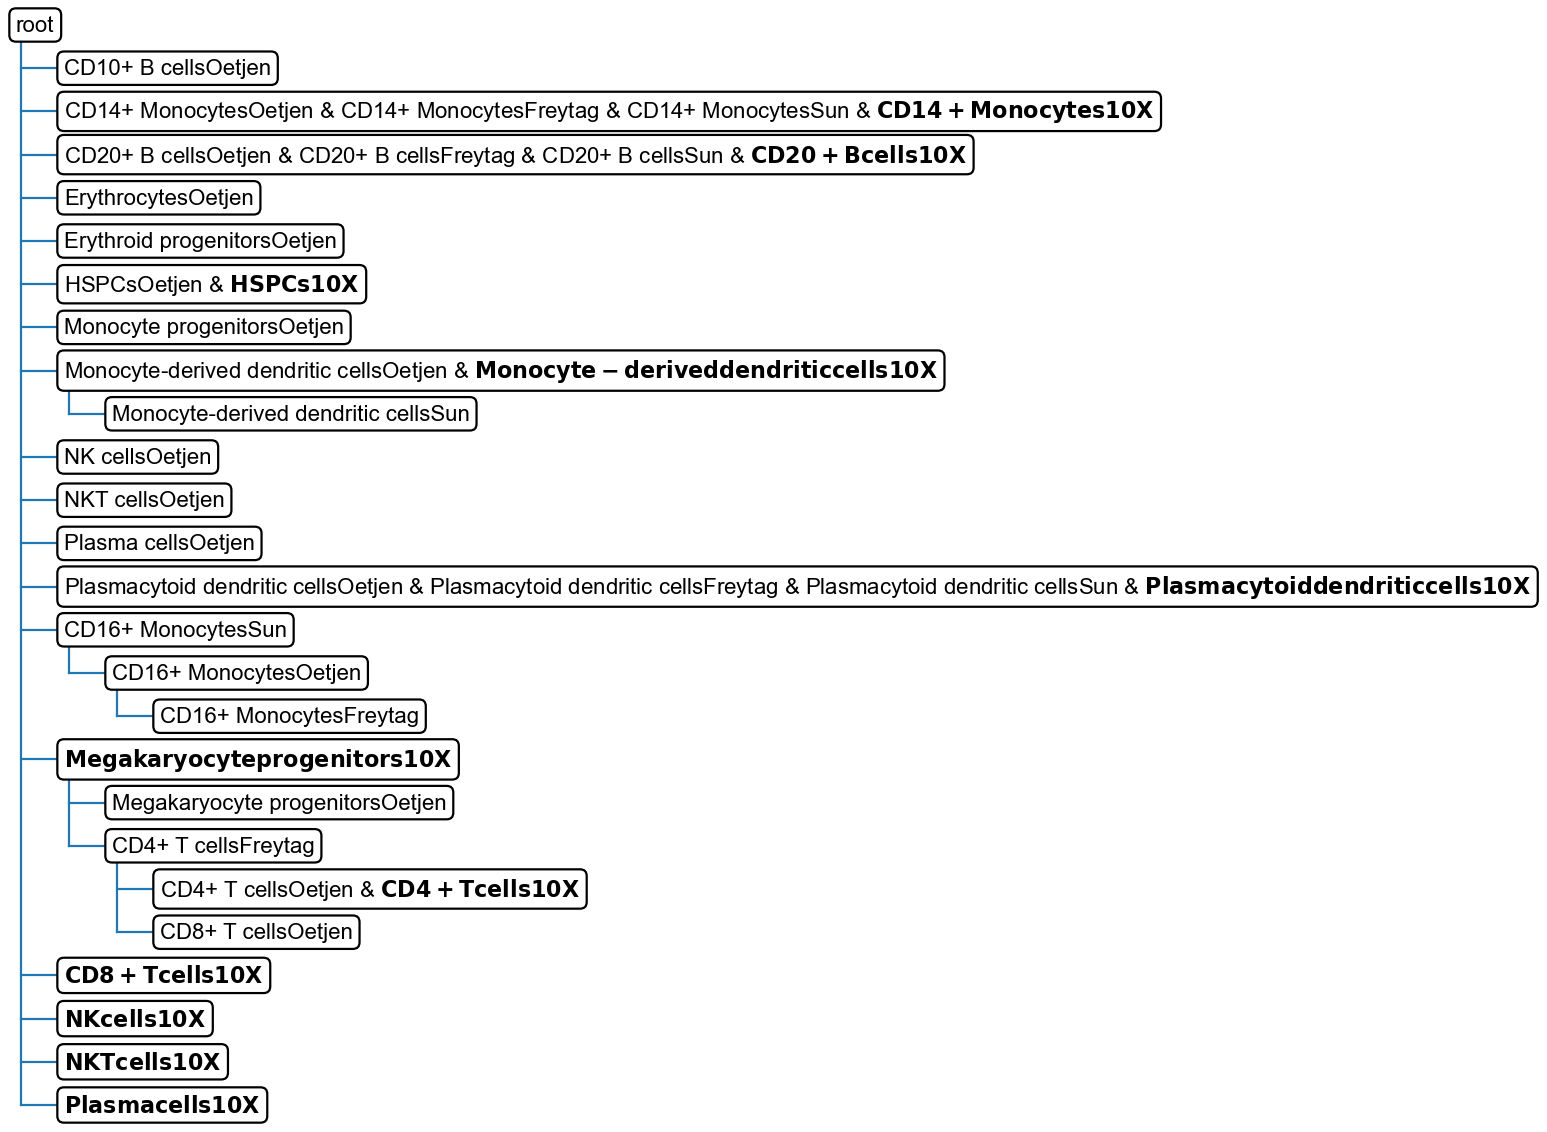

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 2

In [228]:
tree_rq, mp_rq = sca.classifiers.scHPL.learn_tree(data = full_latent, batch_key = 'batch',
                 batch_order = ['10X'],
                 batch_added = ['10X'],
                 cell_type_key='celltype_batch',
                 tree = tree_ref, retrain = False,
                classifier = 'svm',
                dimred = False)